# Insights into Sourcing Cost Trends: Exploring Predictive Modeling Approaches

**This notebook delves into predictive modeling of sourcing costs through two distinct methodologies: regression and forecasting. Prior to modeling, rigorous preprocessing techniques are applied to optimize data quality followed by detection of outliers. Through thorough training and validation processes, both approaches harness the power of advanced algorithms to predict sourcing costs with precision.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading data

In [2]:
data=pd.read_excel('Train.xlsx')
data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,2021-05-01,10.158
1,NTM2,X1,A9,DIRECT,Large,Powder,2020-10-01,134.281
2,NTM3,X2,A20,DIRECT,Large,Powder,2020-12-01,12.456
3,NTM3,X1,A18,WHOLESALE,Small,Powder,2021-02-01,107.220
4,NTM2,X1,A28,DIRECT,Large,Liquid,2020-11-01,197.763


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550176 entries, 0 to 550175
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ProductType        550176 non-null  object        
 1   Manufacturer       550176 non-null  object        
 2   Area Code          550176 non-null  object        
 3   Sourcing Channel   550176 non-null  object        
 4   Product Size       550176 non-null  object        
 5   Product Type       550176 non-null  object        
 6   Month of Sourcing  550176 non-null  datetime64[ns]
 7   Sourcing Cost      550176 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 33.6+ MB


In [4]:
data.describe()

,Month of Sourcing,Sourcing Cost
count,550176,550176.000000
mean,2020-12-08 10:27:28.769848576,108.816793
min,2020-07-01 00:00:00,-196.070000
25%,2020-10-01 00:00:00,57.000000
50%,2020-12-01 00:00:00,132.000000
75%,2021-03-01 00:00:00,146.147000
max,2021-05-01 00:00:00,32632.500000
std,NaN,104.390097


**Since min is negative and assuming that the sourcing cost cannot be negative, I am planning to convert the negatives to positives, also there are some zero values in the sourcing cost, hence the median imputation are done for those values, driven by the same assumption**

### Handling negative values in Sourcing Cost Column

In [5]:
if (data['Sourcing Cost'] < 0).any():
    
    data.loc[data['Sourcing Cost'] < 0, 'Sourcing Cost'] *= -1


### Hnadling zeroes in Sourcing Cost Column

In [6]:
# Count the number of zeros in the "Sourcing Cost" column
num_zeros = (data['Sourcing Cost'] == 0).sum()

print("Number of zeros in the 'Sourcing Cost' column:", num_zeros)


Number of zeros in the 'Sourcing Cost' column: 10084


In [7]:
# Find the median of non-zero values in the "Source Cost" column
median_value = data[data['Sourcing Cost'] != 0]['Sourcing Cost'].median()

# Replace zeros with the median value
data['Sourcing Cost'] = data['Sourcing Cost'].replace(0, median_value)


### Checking for null values 

In [8]:
null_values = data.isnull().sum()
print("Null values in the dataset:\n", null_values)

Null values in the dataset:
 ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
dtype: int64


### Checking for duplicate values

In [9]:

duplicate_rows = data[data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows found in the DataFrame.")
    print(duplicate_rows)
else:
    print("No duplicate rows found in the DataFrame.")


Duplicate rows found in the DataFrame.
       ProductType Manufacturer Area Code Sourcing Channel Product Size  \
63            NTM2           X1       A29           DIRECT        Small   
68            NTM2           X2       A25           DIRECT        Small   
86            NTM1           X1        A7             ECOM        Small   
88            NTM2           X1        A7             ECOM        Large   
93            NTM2           X1       A19           DIRECT        Large   
...            ...          ...       ...              ...          ...   
550171        NTM2           X1        A5           DIRECT        Large   
550172        NTM3           X1       A14           DIRECT        Large   
550173        NTM2           X1        A5           DIRECT        Small   
550174        NTM2           X1        A7           DIRECT        Small   
550175        NTM1           X1        A3           DIRECT        Small   

       Product Type Month of Sourcing  Sourcing Cost  
63   

**Initially considered handling duplicate values, but the dataset was reduced to 8000 rows after removing duplicates. As a result, the prediction values differed significantly from the actual,leading to unreliable predictions. Thus, the approach of removing duplicates was not opted for,
and duplicate values have been retained in the dataset.**

### Extracting the year and month from the datetime

In [10]:
data['year']=pd.DatetimeIndex(data['Month of Sourcing']).year
data['month']=pd.DatetimeIndex(data['Month of Sourcing']).month
data=data.drop(['Month of Sourcing'],axis=1)

In [11]:
data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Sourcing Cost,year,month
0,NTM3,X1,A28,WHOLESALE,Large,Powder,10.158,2021,5
1,NTM2,X1,A9,DIRECT,Large,Powder,134.281,2020,10
2,NTM3,X2,A20,DIRECT,Large,Powder,12.456,2020,12
3,NTM3,X1,A18,WHOLESALE,Small,Powder,107.220,2021,2
4,NTM2,X1,A28,DIRECT,Large,Liquid,197.763,2020,11


### Encoding the categorical values

In [12]:
from sklearn.preprocessing import *
y=data['Sourcing Cost']
x=data.drop(['Sourcing Cost'],axis=1)
x1=x.select_dtypes(include=['object'])
x2=x.select_dtypes(include=['int'])
x2.head()
for i in x1.columns:
    x1[i]=LabelEncoder().fit_transform(x1[i])
x=pd.concat([x1,x2],axis=1)
x.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,year,month
0,2,0,19,3,1,1,2021,5
1,1,0,44,0,1,1,2020,10
2,2,1,12,0,1,1,2020,12
3,2,0,9,3,2,1,2021,2
4,1,0,19,0,1,0,2020,11


### Exploring Categorical Data: Visualizing Categories and Detecting Outliers

**Outlier analysis in the context of categorical data involves identifying class-imbalanced samples. Typically, outlier analysis employs techniques such as the Interquartile Range (IQR) method, which is based on population statistics and involves identifying quartiles.For instance, in the context of a box plot, the IQR (Interquartile Range) is often used to detect outliers. When extending this technique to categorical data, the approach considers samples associated with the majority class as normal data, while those associated with the minority class are regarded as outliers.**

**In this analysis, I utilized frequency analysis of categorical data to detect rare categories, which are then considered as outliers. By examining the distribution of categorical variables, I identified classes that occur infrequently or are significantly underrepresented compared to the majority classes.**

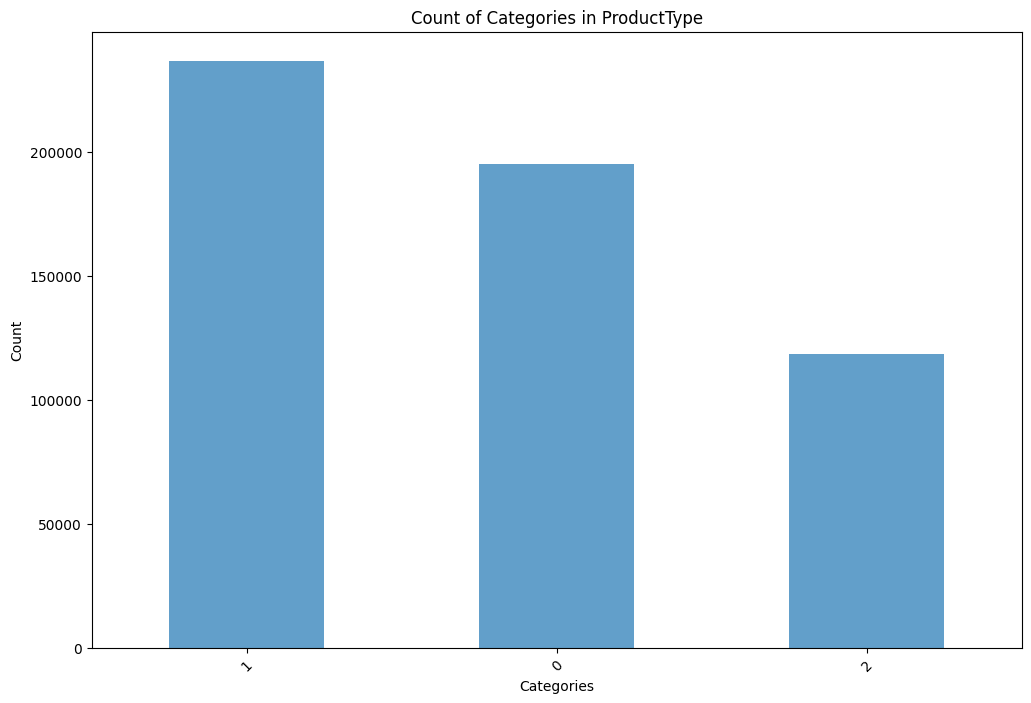

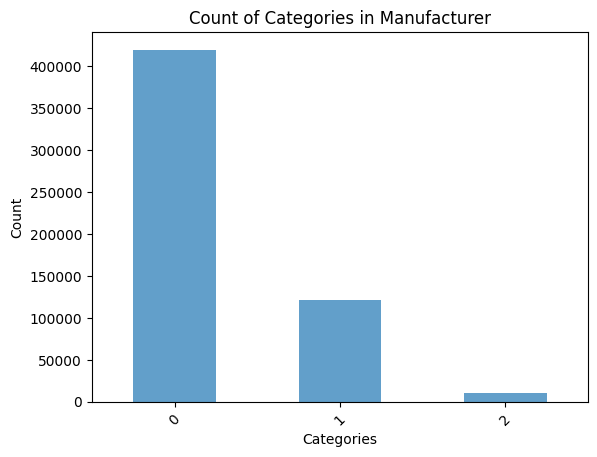

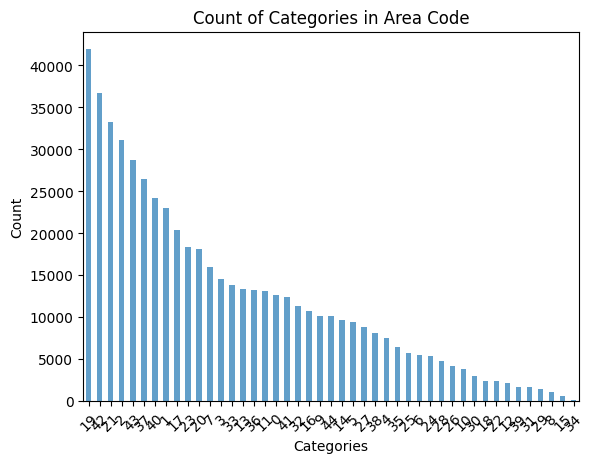

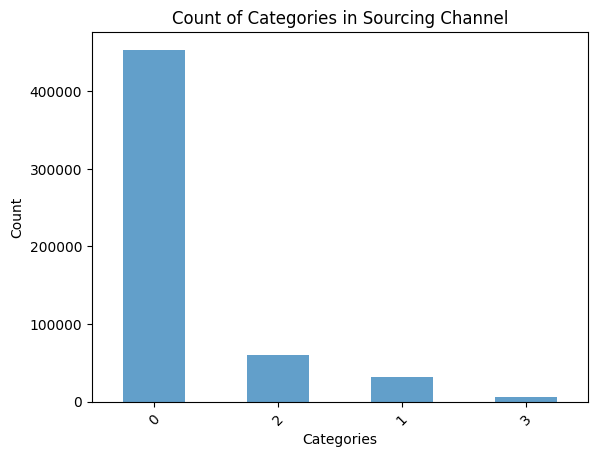

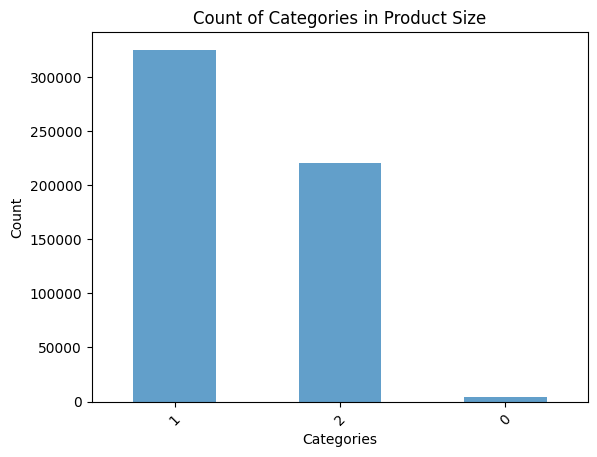

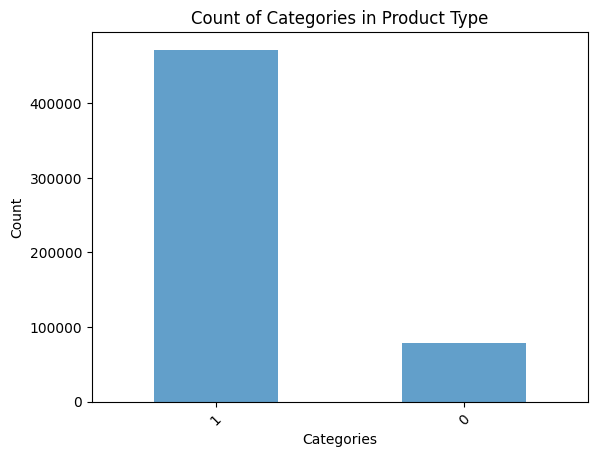

Rare categories in Manufacturer:
Manufacturer
2    0.017493
Name: proportion, dtype: float64

Rare categories in Area Code:
Area Code
37    0.048148
40    0.044080
1     0.041750
17    0.037119
23    0.033406
20    0.032908
7     0.028969
3     0.026441
33    0.025119
13    0.024309
36    0.024054
11    0.023892
0     0.023040
41    0.022536
32    0.020586
16    0.019494
9     0.018456
44    0.018370
14    0.017493
5     0.017129
27    0.016135
38    0.014883
4     0.013719
35    0.011760
25    0.010486
6     0.009990
24    0.009830
28    0.008803
26    0.007723
10    0.006978
30    0.005571
18    0.004290
22    0.004284
12    0.003864
39    0.003148
31    0.003094
29    0.002603
8     0.002070
15    0.001034
34    0.000214
Name: proportion, dtype: float64

Rare categories in Sourcing Channel:
Sourcing Channel
3    0.009891
Name: proportion, dtype: float64

Rare categories in Product Size:
Product Size
0    0.007539
Name: proportion, dtype: float64



In [15]:
# Plot count of categories in each categorical column using bar plot
plt.figure(figsize=(12, 8))
for column in x1.columns:
    x1[column].value_counts().plot(kind='bar', alpha=0.7)
    plt.title(f'Count of Categories in {column}')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Check for rare categories (potential outliers)
threshold = 0.05
rare_categories = {}
for column in x1.columns:
    category_counts = x1[column].value_counts(normalize=True)
    rare_categories[column] = category_counts[category_counts < threshold]

# Print rare categories
for column, categories in rare_categories.items():
    if not categories.empty:
        print(f"Rare categories in {column}:")
        print(categories)
        print()


**Boxplot to visualize spread of values in each categorical column**

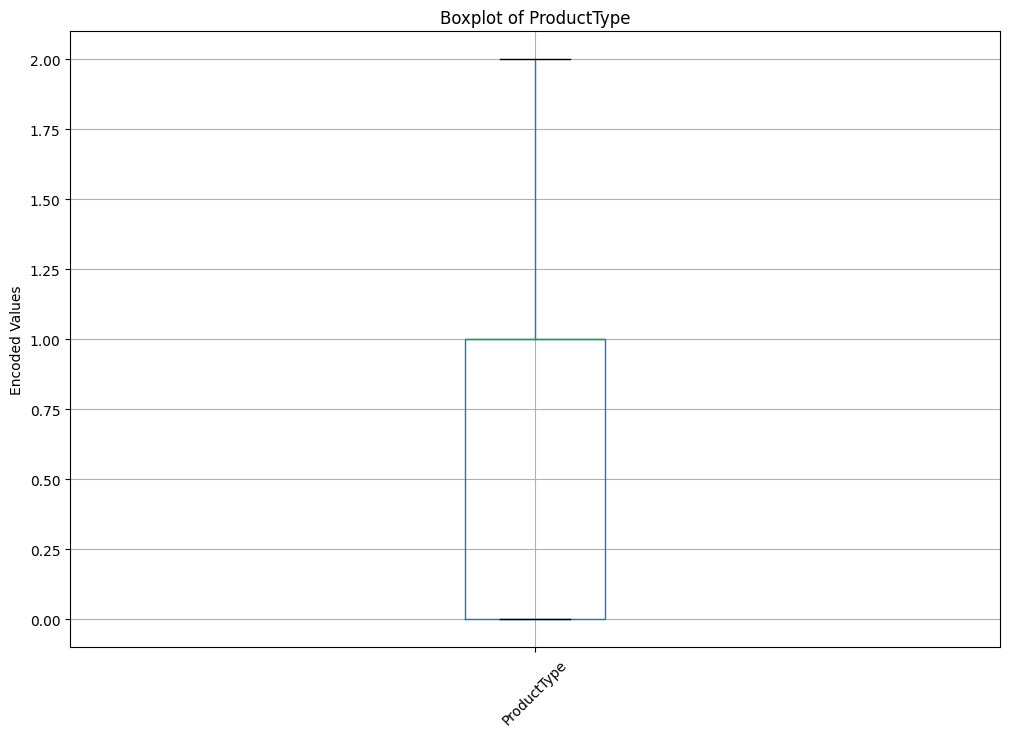

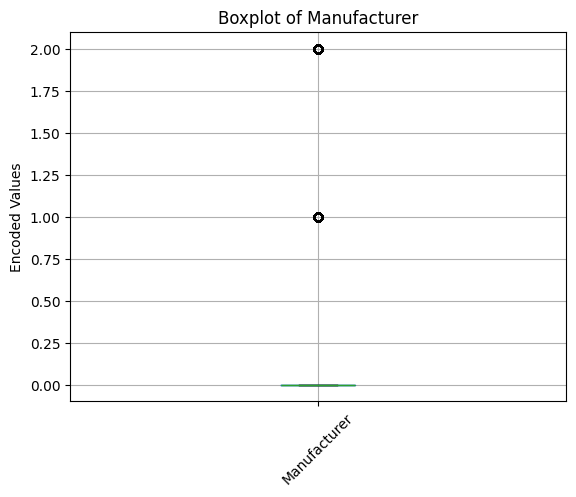

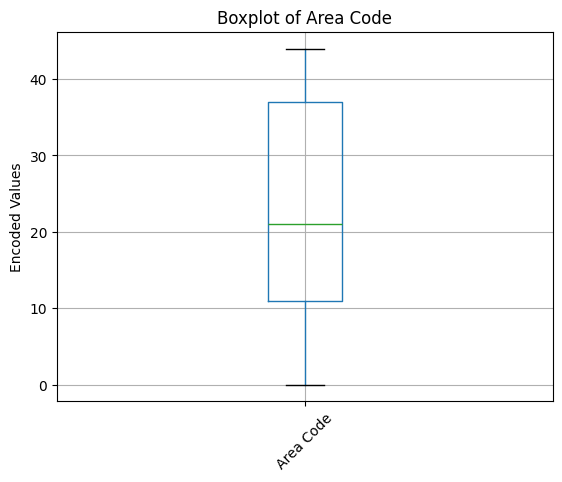

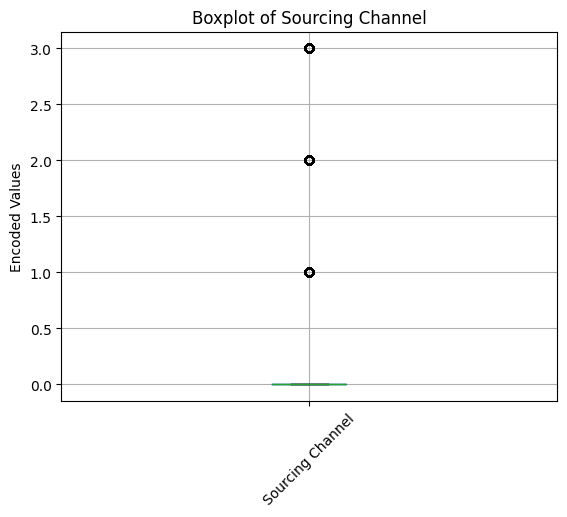

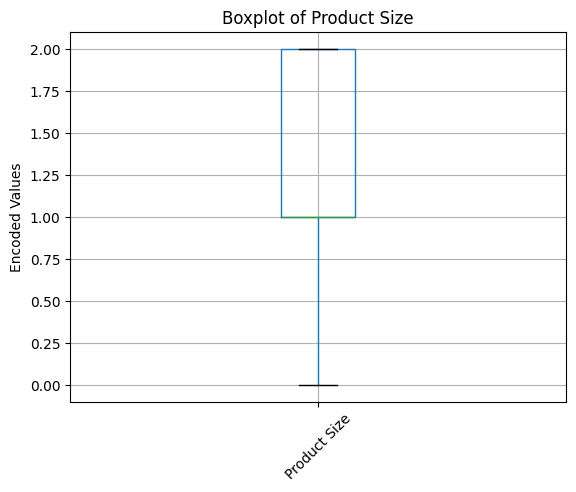

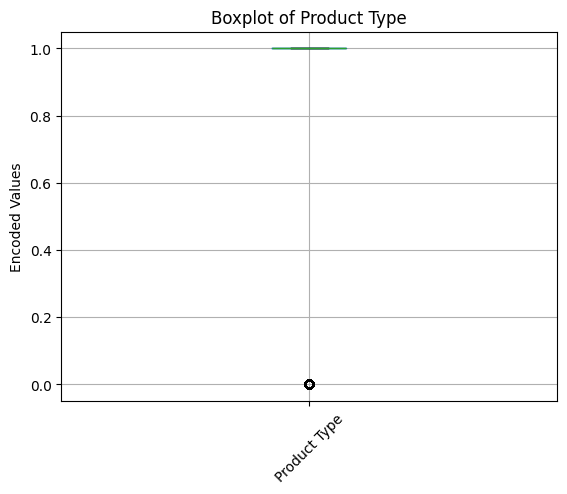

In [16]:
plt.figure(figsize=(12, 8))
for column in x1.columns:
    x1.boxplot(column=column)
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Encoded Values')
    plt.xticks(rotation=45)
    plt.show()

**As observed in the barplot, for the columns like manufacturer, sourcing channel, class imbalance is observed with less samples in minority class. Subsquently, outliers are shown in the boxplot for those particular columns, indicating that the samples from the minority class, become the outlier.**

### Comparison of Count of All Categories and Rare Categories

In [17]:
# Create an empty list to store the comparison results
comparison_list = []


for column in x1.columns:
    all_categories_count = len(x1[column].value_counts())
    rare_categories_str = ', '.join(map(str, rare_categories[column].index))
    comparison_list.append({'Column': column, 'All Categories Count': all_categories_count, 'Rare Categories': rare_categories_str})


print("Comparison of Count of All Categories and Rare Categories:")
for item in comparison_list:
    print(item)


Comparison of Count of All Categories and Rare Categories:
{'Column': 'ProductType', 'All Categories Count': 3, 'Rare Categories': ''}
{'Column': 'Manufacturer', 'All Categories Count': 3, 'Rare Categories': '2'}
{'Column': 'Area Code', 'All Categories Count': 45, 'Rare Categories': '37, 40, 1, 17, 23, 20, 7, 3, 33, 13, 36, 11, 0, 41, 32, 16, 9, 44, 14, 5, 27, 38, 4, 35, 25, 6, 24, 28, 26, 10, 30, 18, 22, 12, 39, 31, 29, 8, 15, 34'}
{'Column': 'Sourcing Channel', 'All Categories Count': 4, 'Rare Categories': '3'}
{'Column': 'Product Size', 'All Categories Count': 3, 'Rare Categories': '0'}
{'Column': 'Product Type', 'All Categories Count': 2, 'Rare Categories': ''}


# Exploratory Data Analysis (EDA)

### Stacked Bar Plot of Categorical Columns

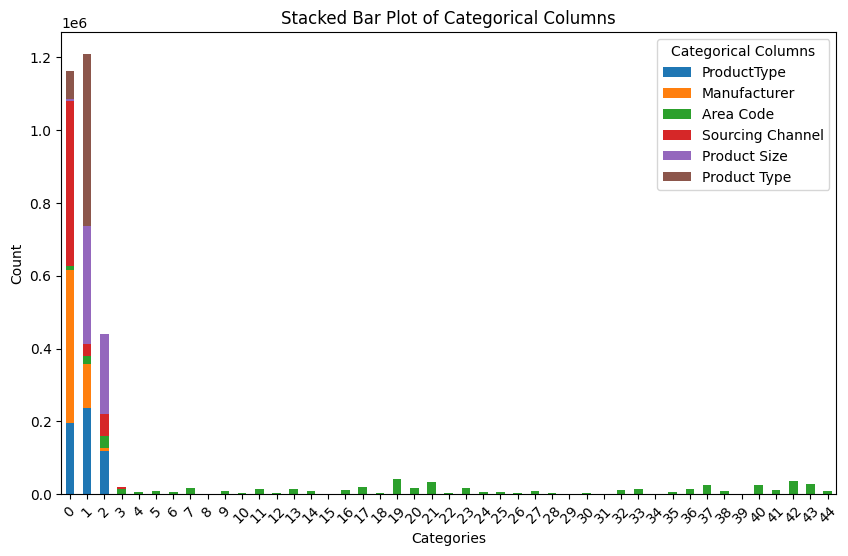

In [18]:
categorical_columns = x1.columns 

category_counts = {}
for column in categorical_columns:
    category_counts[column] = x1[column].value_counts()

category_counts_df = pd.DataFrame(category_counts)

category_counts_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Stacked Bar Plot of Categorical Columns')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Categorical Columns')
plt.show()


In [19]:
!python3 -m pip install seaborn


### Anova Test

**ANOVA is utilized to compare means across multiple groups and determine if there are statistically significant differences between them.**

In [20]:
from scipy.stats import f_oneway




for column in x1.columns:
   
    categorical_feature = x1[column]
    
   
    groups = [y[x1[column] == category] for category in categorical_feature.unique()]
    f_statistic, p_value = f_oneway(*groups)

    
    print(f"\nANOVA results for {column}:")
    print("F-statistic:", f_statistic)
    print("p-value:", p_value)
    if p_value < 0.05:
        print("The p-value is less than 0.05, indicating significant differences exist between groups.")
    else:
        print("The p-value is greater than or equal to 0.05, indicating no significant differences exist between groups.")



ANOVA results for ProductType:
F-statistic: 8288.869943385374
p-value: 0.0
The p-value is less than 0.05, indicating significant differences exist between groups.

ANOVA results for Manufacturer:
F-statistic: 14705.60594497377
p-value: 0.0
The p-value is less than 0.05, indicating significant differences exist between groups.

ANOVA results for Area Code:
F-statistic: 2626.279757300689
p-value: 0.0
The p-value is less than 0.05, indicating significant differences exist between groups.

ANOVA results for Sourcing Channel:
F-statistic: 2827.895018027188
p-value: 0.0
The p-value is less than 0.05, indicating significant differences exist between groups.

ANOVA results for Product Size:
F-statistic: 218.17788178826075
p-value: 1.9235596483278492e-95
The p-value is less than 0.05, indicating significant differences exist between groups.

ANOVA results for Product Type:
F-statistic: 2365.555754273139
p-value: 0.0
The p-value is less than 0.05, indicating significant differences exist betwee

**Based on the ANOVA results for various factors such as Product Type, Manufacturer, Area Code, Sourcing Channel, and Product Size, it is evident that significant differences exist between groups for each of these factors. The low p-values (all less than 0.05) indicate that the observed differences are unlikely to be due to random chance alone.**

### Violin Plot

**Violin plots provide a visual representation of the distribution of data within each category or group. They help determine the shape, spread, and density of the data, facilitating comparisons between different groups and identifying patterns such as skewness, multimodality, and outliers.**

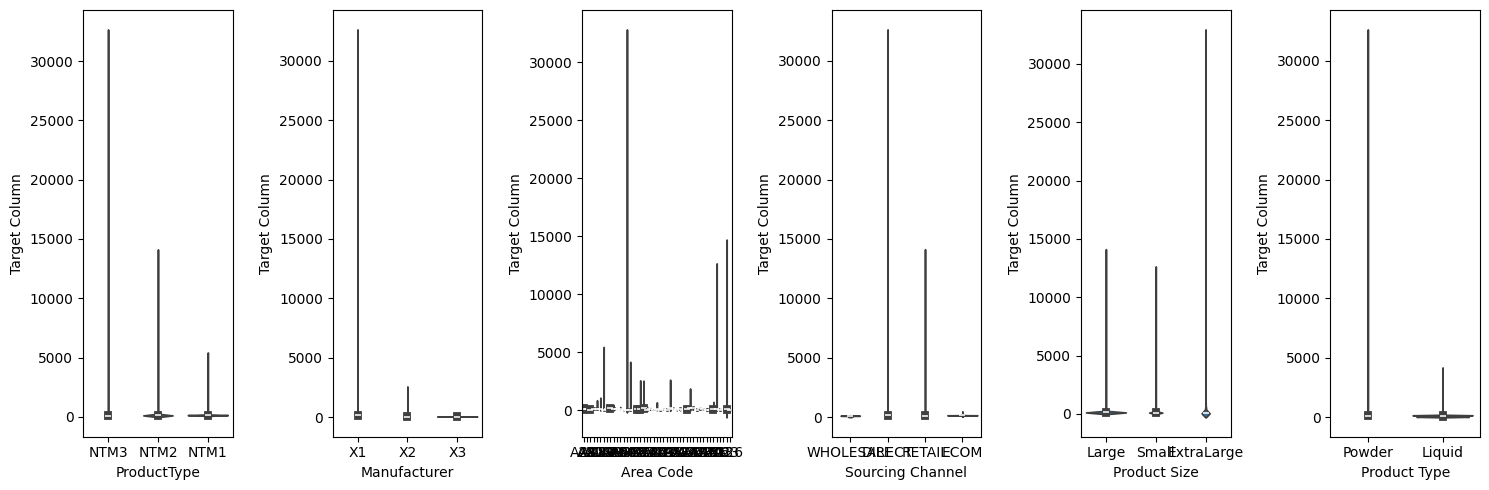

In [22]:
categorical_columns = x1.columns
target_column=y


num_cols = len(categorical_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15, 5)) 


for i, column in enumerate(categorical_columns):
    sns.violinplot(data=data, x=column, y=y, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Target Column')
    
plt.tight_layout()
plt.show()

### Data Splitting

In [23]:
from sklearn.model_selection import *
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

# Approach 1- Regression

**AutoLogging_ML is a library that can be used to compare the performance of classification and regression algorithms in a single line.It is available on Pypi org and can be used to train multiple models at once**

In [24]:
!python3 -m pip install --upgrade AutoLogging_ML

In [25]:
!python3 -m pip install xgboost
!python3 -m pip install catboost

In [26]:
from AutoLogging_ML import AutoLogger
a,model1=AutoLogger.train_and_log_regression(x_train,x_test,y_train,y_test)

Learning rate set to 0.107119
0:	learn: 95.2176141	total: 74.5ms	remaining: 1m 14s
1:	learn: 93.6898015	total: 87.3ms	remaining: 43.6s
2:	learn: 92.4519985	total: 100ms	remaining: 33.4s
3:	learn: 91.4410139	total: 113ms	remaining: 28.1s
4:	learn: 90.4627149	total: 126ms	remaining: 25.1s
5:	learn: 89.7768891	total: 140ms	remaining: 23.1s
6:	learn: 89.2207312	total: 152ms	remaining: 21.6s
7:	learn: 88.6263224	total: 165ms	remaining: 20.5s
8:	learn: 88.2351669	total: 178ms	remaining: 19.6s
9:	learn: 87.9020944	total: 191ms	remaining: 18.9s
10:	learn: 87.5749146	total: 207ms	remaining: 18.6s
11:	learn: 86.9182970	total: 220ms	remaining: 18.1s
12:	learn: 86.4945873	total: 234ms	remaining: 17.7s
13:	learn: 86.2941580	total: 246ms	remaining: 17.3s
14:	learn: 85.8199393	total: 259ms	remaining: 17s
15:	learn: 85.5774001	total: 273ms	remaining: 16.8s
16:	learn: 85.3984615	total: 286ms	remaining: 16.6s
17:	learn: 85.2331628	total: 300ms	remaining: 16.4s
18:	learn: 84.8464517	total: 312ms	remainin

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/AutoLogging_ML/AutoLogger.py:946: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name=dat.loc[b][0]


In [27]:
a

,model,training-mae,training-mse,training-mape,training-r2,training-median absolute error,training-maximum error,validation-mae,validation-mse,validation-mape,validation-r2,validation-median absolute error,validation-maximum error
0,linear regression,3.741028e+01,8.496379e+03,4.796245e+14,9.818388e-02,2.746645e+01,3.252249e+04,3.765543e+01,1.480377e+04,4.422033e+14,5.819988e-02,2.746645e+01,3.252249e+04
1,sgd regression,3.504360e+14,1.264090e+29,2.323017e+27,-1.341721e+25,3.431404e+14,4.444867e+14,3.504771e+14,1.264509e+29,2.150389e+27,-8.044670e+24,3.431404e+14,4.444867e+14
2,ridge regression,3.741028e+01,8.496379e+03,4.796282e+14,9.818388e-02,2.746649e+01,3.252249e+04,3.765544e+01,1.480377e+04,4.422068e+14,5.819988e-02,2.746649e+01,3.252249e+04
3,elastic net,4.212569e+01,8.920978e+03,6.710511e+14,5.311644e-02,3.187790e+01,3.252736e+04,4.234188e+01,1.522939e+04,6.230777e+14,3.112202e-02,3.187790e+01,3.252736e+04
4,decision tree regression,1.335576e+01,5.915909e+03,4.394085e+14,3.720782e-01,2.366610e+00,3.215450e+04,1.381293e+01,1.290875e+04,4.166725e+14,1.787591e-01,2.366610e+00,3.215450e+04
5,random forest regression,1.336238e+01,5.937939e+03,4.396687e+14,3.697398e-01,2.359868e+00,3.215760e+04,1.378900e+01,1.288594e+04,4.171760e+14,1.802104e-01,2.359868e+00,3.215760e+04
6,adaboost regression,3.225723e+01,8.513148e+03,4.494454e+14,9.640403e-02,2.183541e+01,3.107861e+04,3.244309e+01,1.415605e+04,4.137327e+14,9.940703e-02,2.183541e+01,3.107861e+04
7,gradient boost regression,2.113487e+01,7.226907e+03,4.361312e+14,2.329272e-01,9.846047e+00,3.249058e+04,2.149170e+01,1.352279e+04,4.052805e+14,1.396945e-01,9.846047e+00,3.249058e+04
8,xgboost regression,1.360564e+01,5.931910e+03,4.398285e+14,3.703797e-01,2.762588e+00,3.215427e+04,1.403523e+01,1.286210e+04,4.177995e+14,1.817268e-01,2.762588e+00,3.215427e+04
9,bagging regression,1.338456e+01,6.040831e+03,4.399779e+14,3.588187e-01,2.354590e+00,3.215879e+04,1.379058e+01,1.289805e+04,4.172572e+14,1.794397e-01,2.354590e+00,3.215879e+04


In [28]:
model1

HistGradientBoostingRegressor()

In [29]:
c=a.drop([1],axis=0)

<Axes: xlabel='validation-mse', ylabel='model'>

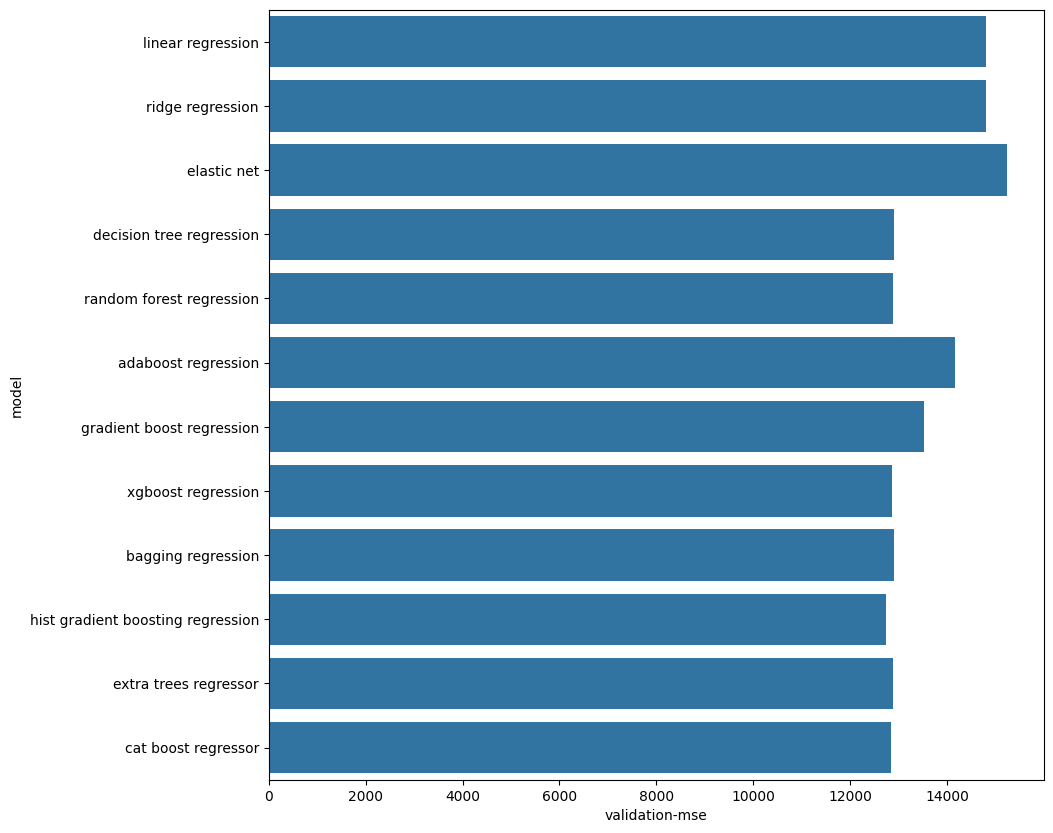

In [30]:
AutoLogger.get_metric_plots_regression(c,'validation','mse')

<Axes: xlabel='validation-mae', ylabel='model'>

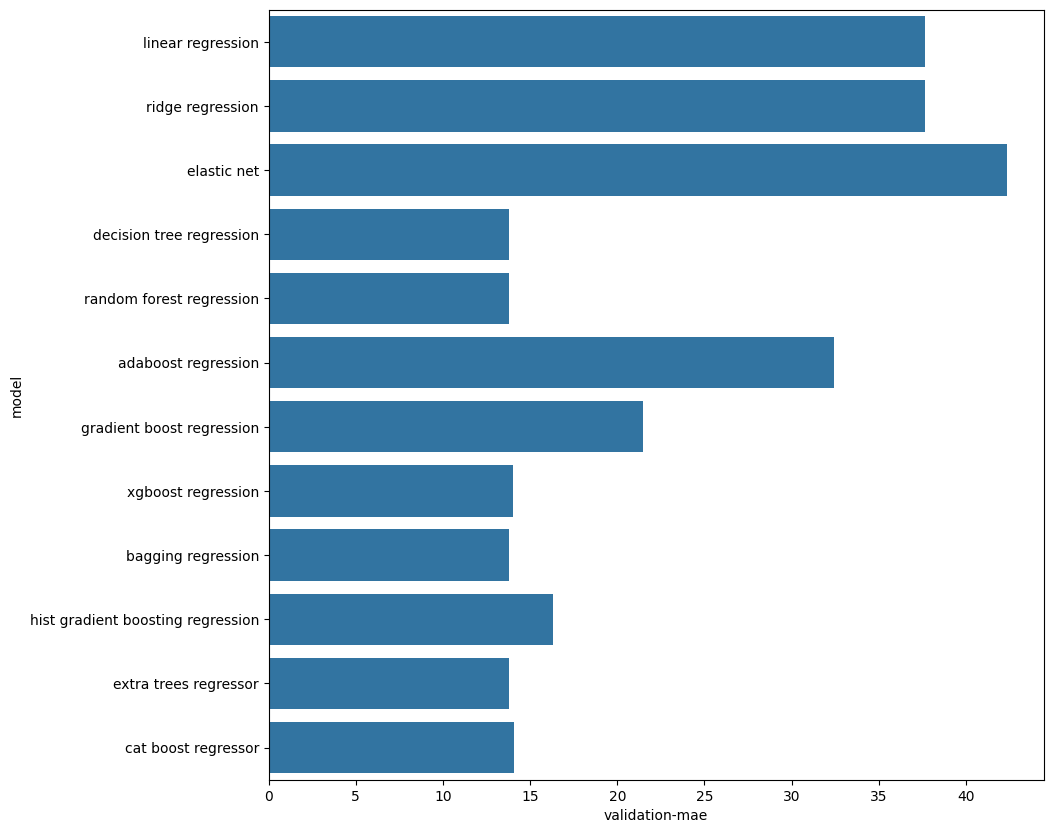

In [31]:
AutoLogger.get_metric_plots_regression(c,'validation','mae')

<Axes: xlabel='validation-r2', ylabel='model'>

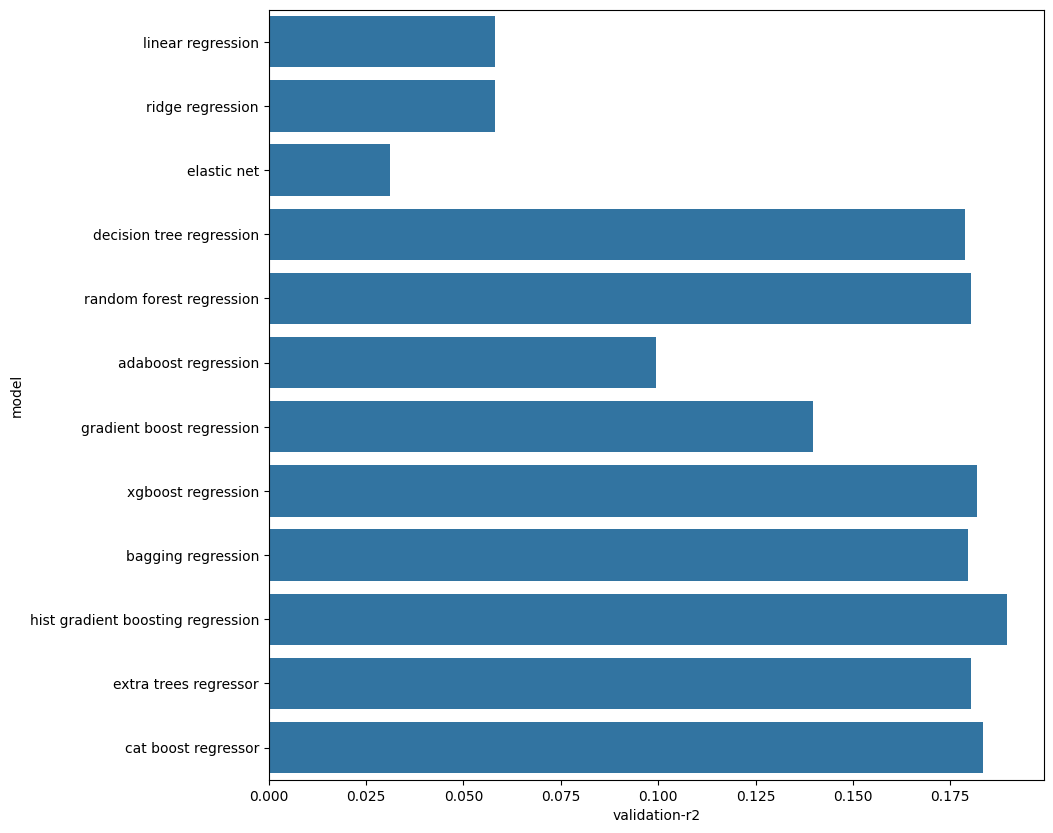

In [32]:
AutoLogger.get_metric_plots_regression(c,'validation','r2')

**After analyzing the models on performance metrics, hist gradient boosting regressor turns out to be the best performing model in terms of validation mse (1.274011e+04) and validation r2 (1.894877e-01) compared to other regressors as shown in the plots and table**

### Testing the model on the test data

In [33]:
test_data=pd.read_excel('Test.xlsx')
test_data['year']=pd.DatetimeIndex(test_data['Month of Sourcing']).year
test_data['month']=pd.DatetimeIndex(test_data['Month of Sourcing']).month
test_data1=test_data.drop(['Month of Sourcing','Sourcing Cost'],axis=1)
x1t=test_data1.select_dtypes(include=['object'])
x2t=test_data1.select_dtypes(include=['int'])
for i in x1t.columns:
    x1t[i]=LabelEncoder().fit_transform(x1t[i])
test_data1=pd.concat([x1t,x2t],axis=1)
test_data['predicted cost']=model1.predict(test_data1)

In [34]:
test_data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,year,month,predicted cost
0,NTM1,X1,A1,DIRECT,Small,Powder,2021-06-21,103.68,2021,6,107.876543
1,NTM1,X1,A10,DIRECT,Large,Powder,2021-06-21,155.75,2021,6,149.496825
2,NTM1,X1,A10,ECOM,Large,Powder,2021-06-21,143.02,2021,6,149.496825
3,NTM1,X1,A11,DIRECT,Large,Powder,2021-06-21,139.39,2021,6,146.509148
4,NTM1,X1,A2,DIRECT,Large,Powder,2021-06-21,169.42,2021,6,165.519075


**Based on the results, the predicted costs closely align with the actual costs across various product types, manufacturers, area codes, and sourcing channels. This suggests that the predictive model estimates the approximately accurate costs, indicating its reliability in forecasting sourcing cost.**

### Making a scatter plot with displacement to visualize the model prediction and comparison with actual values

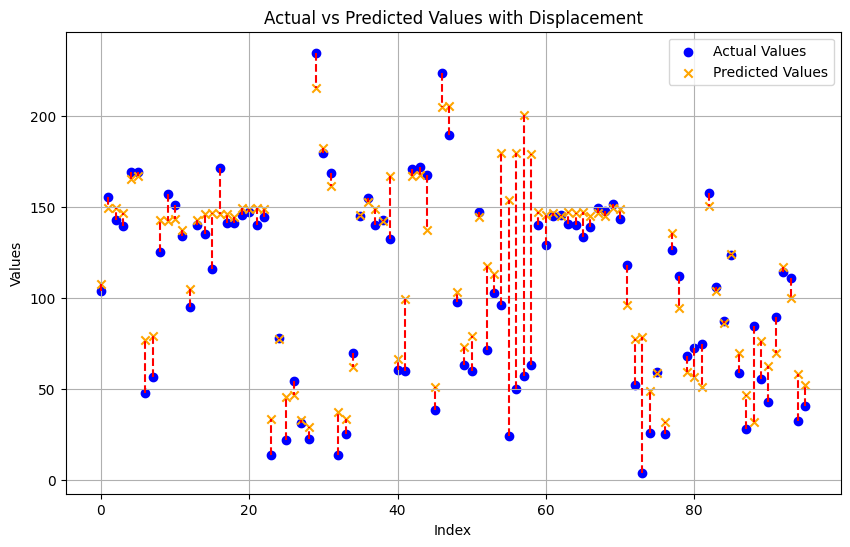

In [35]:
import matplotlib.pyplot as plt
actual_values = test_data['Sourcing Cost']
predicted_values = test_data['predicted cost']
displacement = [actual - predicted for actual, predicted in zip(actual_values, predicted_values)]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_values)), actual_values, label='Actual Values', marker='o', color='blue')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values', marker='x', color='orange')
for i in range(len(actual_values)):
    plt.plot([i, i], [actual_values[i], predicted_values[i]], linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values with Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
print('mean displacement',np.mean(displacement))
print('median displacement',np.median(displacement))

mean displacement -10.707881519118885
median displacement -5.394573191142484


# Approach 2- Forecasting

**Forecasting is a kind of regression problem in which the future values are predicted based on the present and past values. In this case, the input and output are the sourcing cost. The previous day values are taken as input and the current day price is taken as output. Using an iterative sliding window approach, a dataset is created using the single column and regressor algorithms are employed over it.**

**The sourcing cost depends on packaging, transportation, and other material costs, which increases exponentially through time. Hence these factors will exponentially increase the sourcing cost over time. So there would be an increase in the cost over time, and the present values might be relevant to the past, making this kind off suitable for forecasting. This is a mere assumption, which driven me to try out the approach of forecasting**

In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
dat=pd.read_excel('Train.xlsx')
dat['Month of Sourcing'] = pd.to_datetime(dat['Month of Sourcing'])

# Sort the dataset by "Month of Sourcing" column in ascending order
data_sorted = dat.sort_values(by='Month of Sourcing')
data=data_sorted['Sourcing Cost']


def create_sliding_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 5
X, y = create_sliding_windows(data, window_size)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

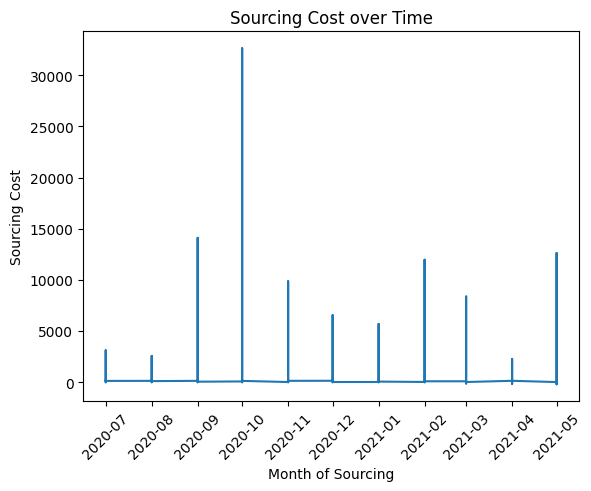

In [42]:
dat_sorted = dat.sort_values(by='Month of Sourcing')

plt.plot(dat_sorted['Month of Sourcing'], dat_sorted['Sourcing Cost'])
plt.xlabel('Month of Sourcing')
plt.ylabel('Sourcing Cost')
plt.title('Sourcing Cost over Time')
plt.xticks(rotation=45)  
plt.show()

**The above line plot is drawn to check presence of relationip between previous day values and change in sourcing cost over time**

In [38]:
from AutoLogging_ML import AutoLogger
aa,model3=AutoLogger.train_and_log_regression(X_train,X_test,y_train,y_test)

Learning rate set to 0.107119
0:	learn: 110.3821330	total: 31.5ms	remaining: 31.5s
1:	learn: 110.3657679	total: 43ms	remaining: 21.5s
2:	learn: 110.3538370	total: 53.8ms	remaining: 17.9s
3:	learn: 109.8890088	total: 63.6ms	remaining: 15.8s
4:	learn: 109.8799840	total: 74.6ms	remaining: 14.8s
5:	learn: 109.8712260	total: 85.8ms	remaining: 14.2s
6:	learn: 109.8616797	total: 96.5ms	remaining: 13.7s
7:	learn: 109.8529865	total: 107ms	remaining: 13.3s
8:	learn: 109.7936271	total: 117ms	remaining: 12.9s
9:	learn: 109.7262038	total: 128ms	remaining: 12.7s
10:	learn: 109.7214108	total: 139ms	remaining: 12.5s
11:	learn: 109.7062055	total: 153ms	remaining: 12.6s
12:	learn: 109.7024858	total: 164ms	remaining: 12.5s
13:	learn: 109.5478050	total: 174ms	remaining: 12.2s
14:	learn: 109.5447370	total: 185ms	remaining: 12.1s
15:	learn: 109.5413584	total: 199ms	remaining: 12.2s
16:	learn: 109.2352184	total: 210ms	remaining: 12.1s
17:	learn: 109.2293555	total: 221ms	remaining: 12.1s
18:	learn: 109.225900

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/AutoLogging_ML/AutoLogger.py:946: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  name=dat.loc[b][0]


In [43]:
aa

,model,training-mae,training-mse,training-mape,training-r2,training-median absolute error,training-maximum error,validation-mae,validation-mse,validation-mape,validation-r2,validation-median absolute error,validation-maximum error
0,linear regression,4.986907e+01,1.218802e+04,9.675645e+15,1.069226e-04,4.023081e+01,6.448764e+03,4.975696e+01,5.728330e+03,9.893209e+15,1.349682e-04,4.023081e+01,6.448764e+03
1,sgd regression,1.077295e+13,1.509288e+26,9.865124e+26,-1.238205e+22,1.082835e+13,5.479689e+14,1.076443e+13,1.410724e+26,9.871670e+26,-2.462383e+22,1.082835e+13,5.479689e+14
2,ridge regression,4.986907e+01,1.218802e+04,9.675645e+15,1.069226e-04,4.023081e+01,6.448764e+03,4.975696e+01,5.728330e+03,9.893209e+15,1.349682e-04,4.023081e+01,6.448764e+03
3,elastic net,4.986916e+01,1.218802e+04,9.675640e+15,1.069136e-04,4.023105e+01,6.448761e+03,4.975703e+01,5.728330e+03,9.893214e+15,1.350137e-04,4.023105e+01,6.448761e+03
4,decision tree regression,1.102409e-04,2.674500e-03,1.691639e-02,9.999998e-01,5.431500e+01,9.725234e+03,6.766572e+01,1.304802e+04,9.843798e+15,-1.277497e+00,5.431500e+01,9.725234e+03
5,random forest regression,1.886772e+01,1.632685e+03,3.513269e+15,8.660561e-01,4.244364e+01,6.445374e+03,5.063189e+01,6.337595e+03,9.744382e+15,-1.062106e-01,4.244364e+01,6.445374e+03
6,adaboost regression,5.232168e+02,7.799403e+05,5.817357e+16,-6.298554e+01,2.629213e+02,5.761470e+03,5.223344e+02,7.768782e+05,5.995282e+16,-1.346021e+02,2.629213e+02,5.761470e+03
7,gradient boost regression,4.958697e+01,1.185476e+04,9.598554e+15,2.744701e-02,4.039049e+01,6.453531e+03,4.956981e+01,5.807328e+03,9.813861e+15,-1.365379e-02,4.039049e+01,6.453531e+03
8,xgboost regression,4.900510e+01,6.511079e+03,9.388943e+15,4.658375e-01,4.104653e+01,1.720809e+04,5.038941e+01,9.339783e+03,9.778343e+15,-6.302346e-01,4.104653e+01,1.720809e+04
9,bagging regression,2.076692e+01,2.047322e+03,3.487166e+15,8.320397e-01,4.488890e+01,6.440518e+03,5.290311e+01,7.859696e+03,9.785874e+15,-3.718892e-01,4.488890e+01,6.440518e+03


In [44]:
model3

ElasticNet()

**After analyzing the models on performance metrics, ElasticNet regressor turns out to be the better performing model in terms of validation mse (5.728330e+03) and validation r2 (1.350137e-04) compared to other regressors as shown in the table**

### Testing the model on test data

In [45]:
test_data1=pd.read_excel('Test.xlsx')
test_data=test_data1['Sourcing Cost']
forecast = []
for i in range(len(test_data) - window_size):
    window = np.array(test_data.iloc[i:i+window_size]).reshape(1, -1)  # Extract window
    forecast.append(model3.predict(window)[0])  # Predict one step ahead

In [46]:
# Printing predicted and actual sourcing cost
print("Predicted Sourcing Cost\t\tActual Sourcing Cost")
for i in range(len(forecast)):
    print(f"{forecast[i]}\t\t\t{test_data.iloc[i+window_size]}")

Predicted Sourcing Cost		Actual Sourcing Cost
108.12633718198543			169.15
107.83860817856106			47.99
108.45318099815023			56.52
108.73484684312847			125.51
108.70178047358927			157.27
108.83913879883114			151.02
109.0052515304178			133.83
108.59791670533083			95.0
108.40545373528894			140.4
108.25481188188138			135.4
108.39393239829998			116.25
108.6010974040322			171.26
108.35655482226024			141.14
108.19783369102595			141.32
108.19484706130291			145.84
108.11664769910807			147.54
107.97157750268487			140.34
108.13144734317994			144.45
108.1054173703782			13.98
108.80352956210798			78.05
108.9589194274878			22.22
109.59759489314172			54.47
109.99238074158507			31.44
110.55284265727015			22.62
110.51654221965565			234.71
109.60082027268707			179.4
109.09355825388934			168.73
108.60503072169146			14.01
108.70782138601486			25.46
108.51913355336983			70.0
109.2229663230372			144.89
109.42421452646693			155.08
109.59148246982902			140.03
109.03266274376661			143.08
108.43525083187511			132

**The results indicate a disparity between predicted costs and actual costs across different product types, manufacturers, area codes, and sourcing channels. This discrepancy implies that the predictive model does not precisely estimate costs, which questions its reliability in forecasting sourcing expenses.**

### Making a scatter plot with displacement to visualize the model prediction and comparison with actual values¶

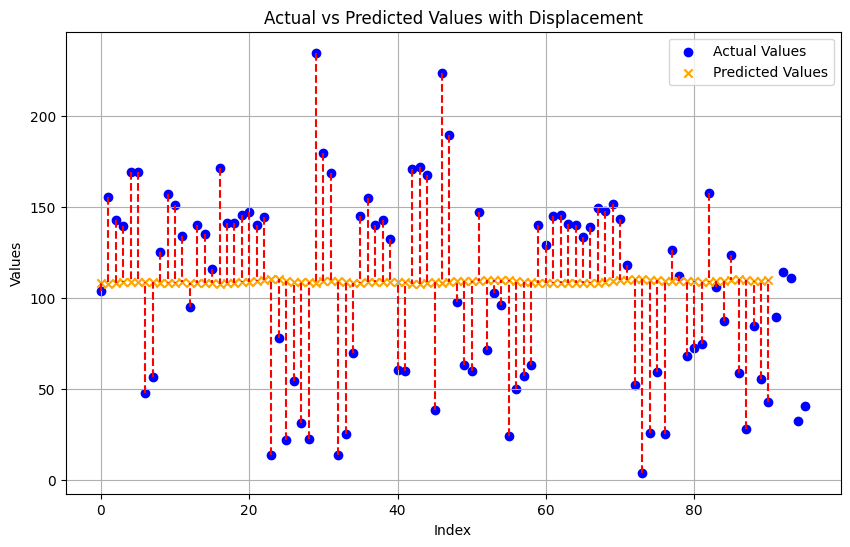

In [47]:
import matplotlib.pyplot as plt
actual_values = test_data1['Sourcing Cost']
predicted_values = forecast
displacement = [actual - predicted for actual, predicted in zip(actual_values, predicted_values)]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(actual_values)), actual_values, label='Actual Values', marker='o', color='blue')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values', marker='x', color='orange')
for i in range(len(actual_values)):
    try:
        plt.plot([i, i], [actual_values[i], predicted_values[i]], linestyle='--', color='red')
    except:
        continue
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values with Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
print('mean displacement',np.mean(displacement))
print('median displacement',np.median(displacement))

mean displacement -1.1999918832349732
median displacement 16.950919103416354


**The primary key performance indicator (KPI) for the different approaches is the mean and median displacement of the actual and predicted values in the testing set apart fron the performance metrics. Since the main objective of the challenge is to bring the predictions as close as possible to the actual ones, analysis using these metrics would be a great aid for evaluating the considered approaches.**

**The final approach under consideration is regression based on its overall performance.**

### Comparison between forecasting and regression in terms of performance:

**Mean and Median Displacement: Negative mean and median displacement values in regression indicate that, on average, the forecasted values are lower than the actual values while a negative mean displacement and a positive median displacement in forecasting indicate that, on average, the forecasted values are slightly lower than the actual values.** 

**Performance Metrics (MSE and R2 Score):The regression approach outperformed the forecasting approach in terms of performance metrics such as MSE and R2 score.A lower MSE indicates that the regression model's predictions are closer to the actual values on average, while a higher R2 score indicates a better fit of the regression model to the data.**

**Input Features:The regression approach likely benefited from the consideration of various input features, which provided more information for the regressors to learn from.In contrast, the forecasting approach relied only on one feature, which may have limited its ability to capture the complexity of the data and make accurate predictions.**